In [4]:
# run_with_new_generator_star.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# Typography / plot style (legends are mechanism names only)
mpl.rc('font', family='serif', serif=['Times New Roman'])
mpl.rcParams.update({
    'text.usetex': False,
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
})
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 30

# --- NEW: data utilities (star model) ---
from data_utils_newest import (
    gen_star_from_x1,       # <-- star/hub generator
    get_true_frequencies,
    gen_progressive,

)

def list_all_correlations(df):
    """
    Return a DataFrame listing all pairwise Pearson correlations:
      Xi, Xj, correlation
    for all i < j.
    """
    cols = list(df.columns)
    results = []

    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            a, b = cols[i], cols[j]
            corr = df[a].astype(float).corr(df[b].astype(float))
            results.append((a, b, corr))

    return pd.DataFrame(results, columns=["Attr1", "Attr2", "PearsonCorr"])

# --- baselines ---
from metrics import compute_mse
from spl import random_split_perturb, random_split_estimate
from rs_fd import rs_fd_perturb, rs_fd_estimate
from rs_rfd import rs_rfd_perturb, rs_rfd_estimate

from corr_rr_fixed_new import (
    corr_rr_phase1_spl,
    corr_rr_phase2_perturb,
    corr_rr_estimate,
    combine_phase_estimates,
    optimal_p_y,
    build_p_y_table,
)

# ---------------- helpers ----------------

def pearson_corr_matrix(df):
    """
    Compute full pairwise Pearson correlation matrix
    across all attributes X1..Xd.
    """
    return df.astype(float).corr()

def _normalize_dist(d):
    vals = np.array([max(0.0, float(v)) for v in d.values()], dtype=float)
    s = vals.sum()
    if s <= 0:
        k = len(vals)
        vals = np.full(k, 1.0 / k)
    else:
        vals = vals / s
    return {k: vals[i] for i, k in enumerate(d.keys())}

def _build_p_y_table_minimal(est_I, epsilon, n2, domain, cols):
    return {
        (a, b): float(optimal_p_y(est_I[a], est_I[b], epsilon, n2, domain))
        for a in cols for b in cols if a != b
    }

# ---------------- one-shot runner ----------------

# ---------------- one-shot runner ----------------
def run_all_once(
    df,
    epsilon,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    cols = list(df.columns)
    domains = {c: sorted(df[c].unique().tolist()) for c in cols}
    true_freqs = get_true_frequencies(df, cols)

    out = {}

    # SPL
    rpt = random_split_perturb(df, epsilon)
    est = random_split_estimate(rpt, df, epsilon)
    out["SPL"] = np.mean([compute_mse(true_freqs[c], est[c]) for c in cols])

    # RS+FD
    pert_rsfd = rs_fd_perturb(df, domains, epsilon)
    est_rsfd = rs_fd_estimate(pert_rsfd, domains, epsilon)
    out["RS+FD"] = np.mean([compute_mse(true_freqs[c], est_rsfd[c]) for c in cols])

    # RS+RFD (two-phase)
    est_I_rsrfd, df_B_rsrfd, doms_rsrfd = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_rsrfd)
    n1_rsrfd = len(df) - len(df_B_rsrfd)
    n2_rsrfd = len(df_B_rsrfd)
    priors_2p = {col: _normalize_dist(est_I_rsrfd[col]) for col in est_I_rsrfd}
    pert_rsrfd_2p = rs_rfd_perturb(df_B_rsrfd, doms_rsrfd, priors_2p, epsilon)
    est_II_rsrfd = rs_rfd_estimate(pert_rsrfd_2p, doms_rsrfd, priors_2p, epsilon)
    combined_rsrfd = combine_phase_estimates(est_I_rsrfd, est_II_rsrfd, n1_rsrfd, n2_rsrfd)
    out["RS+RFD"] = np.mean([compute_mse(true_freqs[c], combined_rsrfd[c]) for c in cols])

    # Corr-RR
    if use_corr_rr:
        est_I, df_B, doms_stable = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_corr)
        n1 = len(df) - len(df_B)
        n2 = len(df_B)
        common_domain = doms_stable[cols[0]]
        p_y_table = _build_p_y_table_minimal(est_I, epsilon, n2, common_domain, cols)
        pert_corr = corr_rr_phase2_perturb(df_B, epsilon, est_I, doms_stable, p_y_table)
        est_II = corr_rr_estimate(pert_corr, doms_stable, epsilon)
        combined_est = combine_phase_estimates(est_I, est_II, n1, n2)
        out["Corr-RR"] = np.mean([compute_mse(true_freqs[c], combined_est[c]) for c in cols])

    return out

In [7]:
def sweep_over_d_star(
    ds=(2, 3, 4, 5, 6),
    epsilon=0.6,
    n=10000,
    R=50,
    corr=0.9,
    domain=None,
    x1_marginal=None,
    q_marginal=None,
    seed=None,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
    plot_dir=None,
    csv_dir=None,
):
    """
    STAR MODEL: For each d in ds,
    1) Generate ONE fixed dataset (X1 pivot model)
    2) Run R repeated mechanism runs on that SAME dataset
    3) Compute mean MSE vs d
    """

    if domain is None:
        domain = [0, 1]
    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(ds), dtype=float) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    for idx, d in enumerate(ds):

        print(f"\n=== Generating STAR dataset for d={d} ===")

        # ----------------------------------------------------
        # ✅ Generate ONE fixed dataset for this attribute count
        # ----------------------------------------------------
        df = gen_star_from_x1(
            n=n,
            domain=domain,
            d=d,
            x1_marginal=x1_marginal,
            rho=corr,
            q_marginal=q_marginal,
            seed=seed if seed is not None else None,
        )

        # Optional: Show correlation list
        corr_list = list_all_correlations(df)
        print(corr_list)

        # ----------------------------------------------------
        # ✅ Run R perturbation-estimation cycles on SAME dataset
        # ----------------------------------------------------
        for run in range(R):
            res = run_all_once(
                df,
                epsilon,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac_phase1_corr,
                frac_phase1_rsrfd=frac_phase1_rsrfd,
            )
            for k in keys:
                means[k][idx] += res[k]

        for k in keys:
            means[k][idx] /= R

    # --------------------------------------------------------
    # ✅ Plot results (MSE vs d)
    # --------------------------------------------------------
    plt.figure(figsize=(10, 8))
    plt.plot(ds, means["SPL"],   '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(ds, means["RS+FD"], '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(ds, means["RS+RFD"],'-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(ds, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')

    plt.xlabel('Number of Attributes', fontsize=40)
    plt.ylabel('MSE', fontsize=40)
    plt.xticks(ds, labels=[str(x) for x in ds])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.legend(fontsize=35, loc='upper left', frameon=True, edgecolor='black')
    plt.tight_layout()

    # Save output
    def _fmt(x): return f"{x:g}"
    base = f"mseVSd_star_eps_{_fmt(epsilon)}_n_{n}_rho_{_fmt(corr)}_k_{len(domain)}"

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, base + ".pdf"), format="pdf")

    plt.show()

    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        df_out = pd.DataFrame({"d": list(ds)})
        for k in keys:
            df_out[k] = means[k]
        df_out.to_csv(os.path.join(csv_dir, base + ".csv"), index=False)

    return means
def sweep_over_d_progressive(
    ds=(2, 3, 4, 5, 6),
    epsilon=0.6,
    n=10000,
    R=50,
    rho=0.9,
    domain=None,
    x1_marginal=None,
    q_marginal=None,
    seed=None,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
    plot_dir=None,
    csv_dir=None,
):
    """
    PROGRESSIVE MODEL: For each d in ds,
    1) Generate ONE dataset using progressive dependencies
    2) Run R perturbation-estimation cycles on SAME dataset
    3) Compute mean MSE vs d
    """

    if domain is None:
        domain = [0, 1]
    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(ds), dtype=float) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    for idx, d in enumerate(ds):

        print(f"\n=== Generating PROGRESSIVE dataset for d={d} ===")

        # ----------------------------------------------------
        # ✅ Generate one dataset for this attribute count
        # ----------------------------------------------------
        df = gen_progressive(
            n=n,
            domain=domain,
            d=d,
            x1_marginal=x1_marginal,
            rho=rho,
            q_marginal=q_marginal,
            seed=seed if seed is not None else None,
        )

        # Optional: correlation info
        corr_list = list_all_correlations(df)
        print(corr_list)

        # ----------------------------------------------------
        # ✅ Run multiple trials on SAME dataset
        # ----------------------------------------------------
        for run in range(R):
            res = run_all_once(
                df,
                epsilon,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac_phase1_corr,
                frac_phase1_rsrfd=frac_phase1_rsrfd,
            )
            for k in keys:
                means[k][idx] += res[k]

        for k in keys:
            means[k][idx] /= R

    # --------------------------------------------------------
    # ✅ Plot MSE vs d
    # --------------------------------------------------------
    plt.figure(figsize=(10, 8))
    plt.plot(ds, means["SPL"],   '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(ds, means["RS+FD"], '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(ds, means["RS+RFD"],'-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(ds, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')

    plt.xlabel('Number of Attributes', fontsize=40)
    plt.ylabel('MSE', fontsize=40)
    plt.xticks(ds, labels=[str(x) for x in ds])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.legend(fontsize=35, loc='upper left', frameon=True, edgecolor='black')
    plt.tight_layout()

    base = f"mseVSd_progressive_eps_{epsilon}_n_{n}_rho_{rho}_k_{len(domain)}"

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, base + ".pdf"), format="pdf")

    plt.show()

    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        df_out = pd.DataFrame({"d": list(ds)})
        for k in keys:
            df_out[k] = means[k]
        df_out.to_csv(os.path.join(csv_dir, base + ".csv"), index=False)

    return means



=== Generating STAR dataset for d=2 ===
  Attr1 Attr2  PearsonCorr
0    X1    X2     0.123285

=== Generating STAR dataset for d=3 ===
  Attr1 Attr2  PearsonCorr
0    X1    X2     0.123285
1    X1    X3     0.068799
2    X2    X3    -0.003087

=== Generating STAR dataset for d=4 ===
  Attr1 Attr2  PearsonCorr
0    X1    X2     0.123285
1    X1    X3     0.068799
2    X1    X4     0.046633
3    X2    X3    -0.003087
4    X2    X4    -0.012397
5    X3    X4     0.023423

=== Generating STAR dataset for d=5 ===
  Attr1 Attr2  PearsonCorr
0    X1    X2     0.123285
1    X1    X3     0.068799
2    X1    X4     0.046633
3    X1    X5     0.123121
4    X2    X3    -0.003087
5    X2    X4    -0.012397
6    X2    X5     0.013224
7    X3    X4     0.023423
8    X3    X5    -0.001984
9    X4    X5     0.021309

=== Generating STAR dataset for d=6 ===
   Attr1 Attr2  PearsonCorr
0     X1    X2     0.123285
1     X1    X3     0.068799
2     X1    X4     0.046633
3     X1    X5     0.123121
4     X

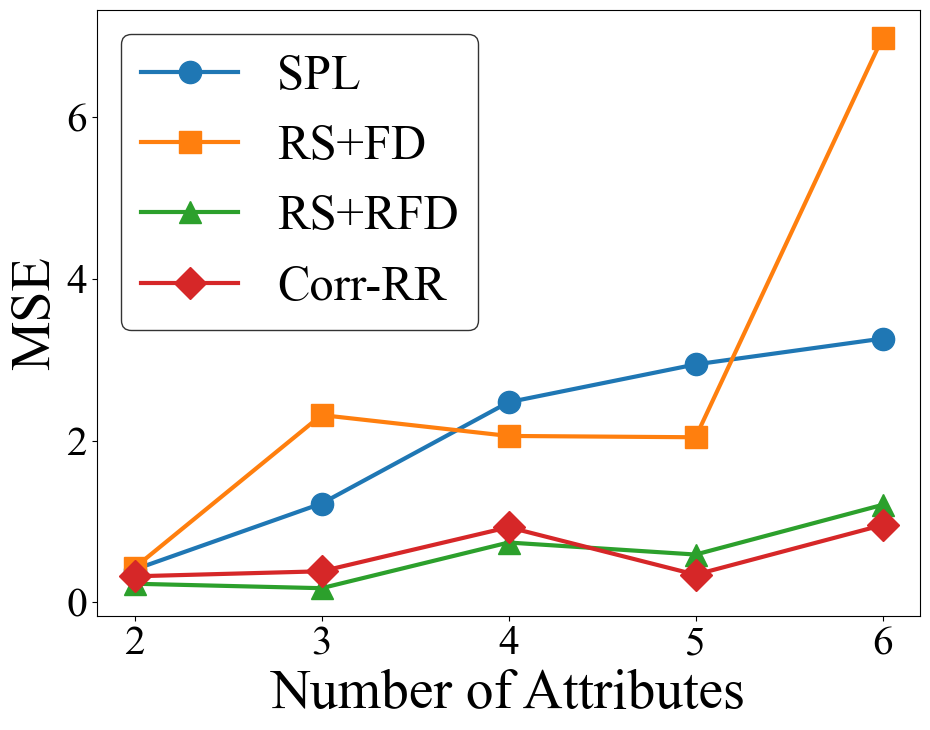

In [15]:
# ---------------- example usage (fixed epsilon, vary d) ----------------






if __name__ == "__main__":
    # Choose a fixed epsilon
    fixed_eps = 0.1

    # Attribute counts to test
    ds = [2, 3, 4, 5, 6]
    #ds = [2]

    # Data spec (reuse your earlier choices or tweak)
    domain = [0, 1, 2, 3]
    x1_marginal = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1}
    rho = 0.1
    q = None  # uniform for non-copy branch

    means_d = sweep_over_d_star(
        ds=ds,
        epsilon=fixed_eps,
        n=2000,
        R=1,
        corr=rho,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        #plot_dir=r"C:\\Users\\ss6365\\Desktop\\pet_30_fig",
        #csv_dir=r"C:\\Users\\ss6365\\Desktop\\pet_30_fig\\data",
    )



=== Generating PROGRESSIVE dataset for d=2 ===
  Attr1 Attr2  PearsonCorr
0    X1    X2     0.123285

=== Generating PROGRESSIVE dataset for d=3 ===
  Attr1 Attr2  PearsonCorr
0    X1    X2     0.123285
1    X1    X3     0.014667
2    X2    X3     0.076823

=== Generating PROGRESSIVE dataset for d=4 ===
  Attr1 Attr2  PearsonCorr
0    X1    X2     0.123285
1    X1    X3     0.014667
2    X1    X4     0.002019
3    X2    X3     0.076823
4    X2    X4    -0.044074
5    X3    X4     0.091355

=== Generating PROGRESSIVE dataset for d=5 ===
  Attr1 Attr2  PearsonCorr
0    X1    X2     0.123285
1    X1    X3     0.014667
2    X1    X4     0.002019
3    X1    X5    -0.008844
4    X2    X3     0.076823
5    X2    X4    -0.044074
6    X2    X5     0.032474
7    X3    X4     0.091355
8    X3    X5     0.093395
9    X4    X5     0.005878

=== Generating PROGRESSIVE dataset for d=6 ===
   Attr1 Attr2  PearsonCorr
0     X1    X2     0.123285
1     X1    X3     0.014667
2     X1    X4     0.002019


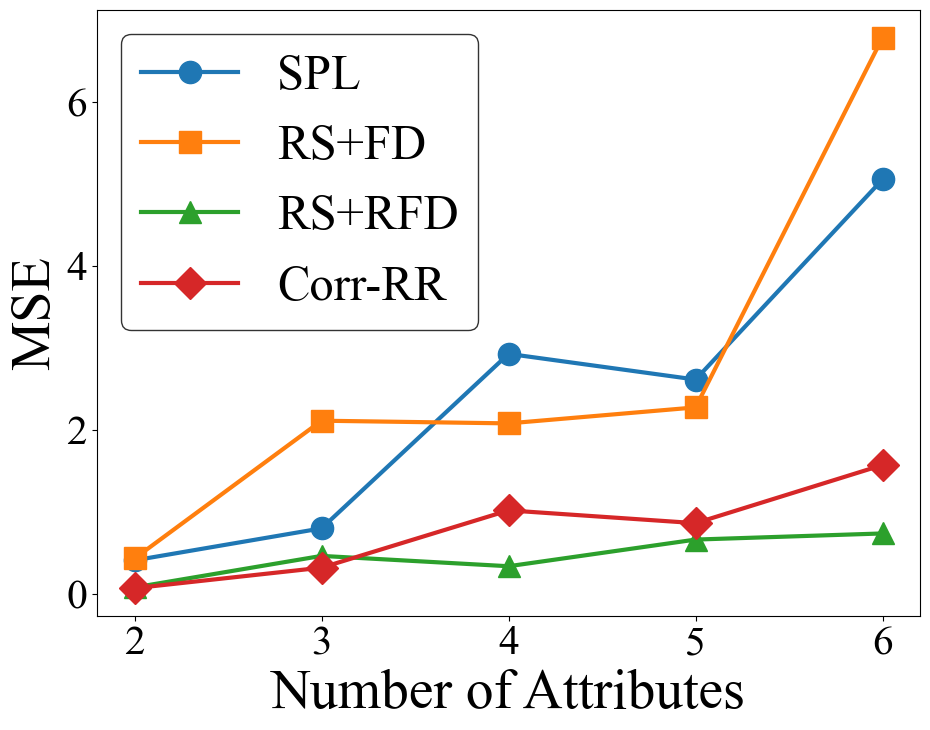

In [13]:
# ---------------- example usage (fixed epsilon, vary d) ----------------






if __name__ == "__main__":
    # Choose a fixed epsilon
    fixed_eps = 0.1

    # Attribute counts to test
    ds = [2, 3, 4, 5, 6]
   # ds = [2]

    # Data spec (reuse your earlier choices or tweak)
    domain = [0, 1, 2, 3]
    x1_marginal = {0: 0.4, 1: 0.3, 2: 0.2, 3: 0.1}
    rho = 0.1
    q = None  # uniform for non-copy branch

    means_d = sweep_over_d_progressive(
        ds=ds,
        epsilon=fixed_eps,
        n=2000,
        R=1,
        rho=rho,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        #plot_dir=r"C:\\Users\\ss6365\\Desktop\\pet_30_fig",
        #csv_dir=r"C:\\Users\\ss6365\\Desktop\\pet_30_fig\\data",
    )
